# Data Scientist Professional Case Study

### Company Background

National Accessibility currently installs wheelchair ramps for office buildings and schools. The marketing manager wants the company to start installing ramps for event venues as well. According to a new survey, approximately 40% of event venues are not wheelchair accessible. However, it is not easy to know whether a venue already has a ramp installed.

It is a waste of time to contact venues that already have a ramp installed, and it also looks bad for the company. They would like the help of the data science team in predicting which venues already have a ramp installed. 

### Customer Question

The marketing manager would like to know:
- Can you develop a model to predict whether an event venue already has a wheelchair ramp installed?

### Success Criteria

To reduce the amount of time wasted by the company contacting venues that already have a ramp, at least two-thirds of venues predicted to be without a ramp should not have a ramp. 


### Dataset


The data you will use for this analysis can be accessed here: `"data/event_venues.csv"`

# Index
1. Task Review
2. Data Overview
3. EDA and Feature Engineering
4. Model Building
5. Model Evaluation
6. Recommendation


### 1. Task Review

The first step to solving assigned tasks is Understanding the Problem. Based on the instructions above, this looks like a Supervised Machine Learning Classification task with a threshold for the accuracy

### 2. Data Overview
The second step to executing a sound Machine Learning model is Understanding the Data. The data to be used in this project has been coallated and made available to us, along with a table to explain each variable. The data is availaible in this format: column name; data type, variable explanation.

venue_name; Character, name of the venue.
Loud music / events; Character, whether the venue hosts loud events (True) or
not (False).
Venue provides alcohol; Numeric, whether the venue provides alcohol (1) or not (0).
Wi-Fi; Character, whether the venue provides wi-fi (True) or not
(False).
supervenue; Character, whether the venue qualifies as a supervenue
(True) or not (False).
U-Shaped_max; Numeric, the total capacity of the u-shaped portion of the
theatre.
max_standing; Numeric, the total standing capacity of the venue.
Theatre_max; Numeric, the total capacity of the theatre.
Promoted / ticketed events; Character, whether the venue hosts promoted/ticket
events (True) or not (False).
Wheelchair accessible; Character, whether the venue is wheelchair accessible
(True) or not (False).

### 3. Exploratory Data Analysis and Feature Engineering
Now that we understand the data, we can go on to bring it into the notebook, perform the necessary EDA and see if the need arises for feature engineering

In [79]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [80]:
# Import data
df = pd.read_csv("data/event_venues.csv")
display(df.head())
df.shape

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,techspace aldgate east,False,0,True,False,35.045455,0,112.715867,False,False
1,green rooms hotel,True,1,True,False,40.000000,120,80.000000,True,False
2,148 leadenhall street,False,0,True,False,35.045455,0,112.715867,False,False
3,conway hall,False,0,True,False,35.045455,60,60.000000,False,False
4,gridiron building,False,0,True,False,35.045455,0,112.715867,False,False


(3910, 10)

It looks like there are no missing values, but we'll double check and also check for duplicates in the data.

In [81]:
#Missing Values Check
df.isna().sum()

venue_name                    0
Loud music / events           0
Venue provides alcohol        0
Wi-Fi                         0
supervenue                    0
U-Shaped_max                  0
max_standing                  0
Theatre_max                   0
Promoted / ticketed events    0
Wheelchair accessible         0
dtype: int64

In [82]:
#Duplicates Check
df.duplicated().sum()

450

In [83]:
#create checkpoint
orig_df = df.copy()

There appears to be a considerable number of duplicates which could adversely affect our model. Let's remove them before moving on.

In [84]:
df.drop_duplicates(inplace=True)

#Validating that the duplicates were dropped
df.duplicated().sum()

0

In [85]:
#Confirm data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3460 non-null   object 
 1   Loud music / events         3460 non-null   bool   
 2   Venue provides alcohol      3460 non-null   int64  
 3   Wi-Fi                       3460 non-null   bool   
 4   supervenue                  3460 non-null   bool   
 5   U-Shaped_max                3460 non-null   float64
 6   max_standing                3460 non-null   int64  
 7   Theatre_max                 3460 non-null   float64
 8   Promoted / ticketed events  3460 non-null   bool   
 9   Wheelchair accessible       3460 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 179.1+ KB


It is clear that the capacity of the venues are broken into the U-Shaped max, max_standing and Theatr_max columns, I'll perform a validation exercise to make sure this value is not out of range.

In [86]:
df['total_capacity'] = df['U-Shaped_max'] + df['max_standing'] + df['Theatre_max']
out_of_range = df[df['total_capacity']<0]
out_of_range.shape

(0, 11)

There is no impossible value as we can see by the empty dataframe. Now to get the summary statisitcs of dataframe.

In [87]:
#Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Venue provides alcohol,3460.0,0.743353,0.436846,0.0,0.000000,1.000000,1.000000,1.000000
U-Shaped_max,3460.0,35.093431,46.643692,1.0,35.045455,35.045455,35.045455,2520.000000
max_standing,3460.0,126.390462,285.898114,0.0,20.000000,60.000000,150.000000,7500.000000
Theatre_max,3460.0,113.287819,138.630541,1.0,70.000000,112.715867,112.715867,4000.000000
total_capacity,3460.0,274.771712,376.211219,7.0,147.761322,195.045455,297.761322,8035.045455


It appears there U-shaped max and Theatre max are both floats when they should be integers because it's unreasonable to measure capacity in decimal points and also a large portion of the data in this column are in a small range. Let's look at some values in both columns and the summary statistics of the Dataframe before making a decision on their fate.

In [88]:
df[['U-Shaped_max', 'Theatre_max']].head(10)

,U-Shaped_max,Theatre_max
0,35.045455,112.715867
1,40.000000,80.000000
2,35.045455,112.715867
3,35.045455,60.000000
4,35.045455,112.715867
5,6.000000,112.715867
6,35.045455,112.715867
7,35.045455,112.715867
8,35.045455,112.715867
9,35.045455,20.000000


Seeing that all the float entries are one value in both cases, I notice that this variable was missing for alot during collection and then filled in with the average value (as deduced by the summary statistics). It is interesting that this was carried out for both this columns but not for max_standing. Let's find out just how many values were imputed.

In [89]:
df[['U-Shaped_max', 'Theatre_max', 'total_capacity']] = df[['U-Shaped_max', 'Theatre_max', 'total_capacity']].astype('int')

U_imputed = df[(df['U-Shaped_max']==35)]
Theatre_imputed = df[(df['Theatre_max']==112)]
one_imputed = df[(df['U-Shaped_max']==35)|(df['Theatre_max']==112)]
both_imputed = df[(df['U-Shaped_max']==35)&(df['Theatre_max']==112)]
only_imputed = df[(df['total_capacity']==147)]

print('There are {} rows with the U-Shaped_max variable imputed'.format(U_imputed.shape[0]))
print('There are {} rows with the Theatre_max variable imputed'.format(Theatre_imputed.shape[0]))
print('There are {} rows with with either the U-Shaped_max or the Theatre_max variable imputed'.format(one_imputed.shape[0]))
print('There are {} rows with both the U-Shaped_max or the Theatre_max variables imputed'.format(both_imputed.shape[0]))
print('There are {} rows with both the U-Shaped_max or the Theatre_max variables imputed and zero in the max standing variable.'.format(only_imputed.shape[0]))


There are 2529 rows with the U-Shaped_max variable imputed
There are 1894 rows with the Theatre_max variable imputed
There are 2645 rows with with either the U-Shaped_max or the Theatre_max variable imputed
There are 1778 rows with both the U-Shaped_max or the Theatre_max variables imputed
There are 327 rows with both the U-Shaped_max or the Theatre_max variables imputed and zero in the max standing variable.


Going by the values we can see above, a large number of values were imputed and this will no doubt have an adverse effect on model and they are too large to drop. We'll bring this up in the presentation.

Let's visualize the sum of our continous variables in the context of our target variable to get a good feel of the data.

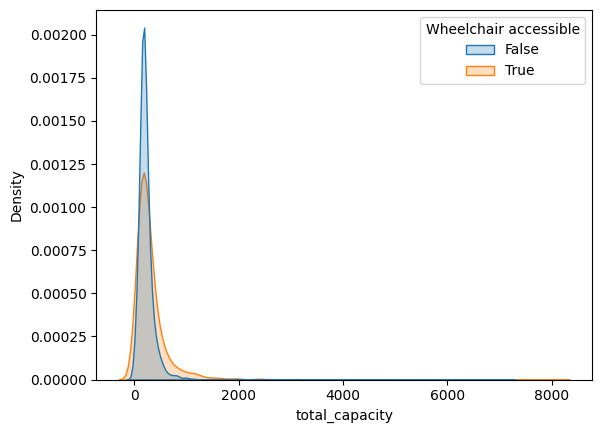

In [90]:
sns.kdeplot(df['total_capacity'], hue=df['Wheelchair accessible'], shade=True)
plt.show()

It looks like our data is skewed due to the presence of outliers and the sharp peak of the graph indicates a concentration of values in a small range which i theorize is because of the mean-filling done in the data preprocessing. Let's look at the outliers before making a decision.
Also we can see no distinctive difference in the two plots, indicating a very weak correlation between the discrete variables and the target variable, we'll test this later on to be sure.

In [91]:
# Computing quantile boundaries
q1 = np.quantile(df['total_capacity'], 0.25)
q3 = np.quantile(df['total_capacity'], 0.75)
iqr = q3 - q1

# Calculate the lower and upper cutoffs for outliers
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Subset the data to find outliers
outliers = df[(df['total_capacity']<lower)|(df['total_capacity']>upper)]
display(outliers)

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible,total_capacity
21,grand ballroom at the montcalm,False,0,True,False,35,500,450,False,False,985
38,clothworkers' hall,True,0,True,False,180,350,240,True,False,770
99,skylight,False,1,True,False,35,400,112,False,False,547
112,the chelsea lodge,True,1,True,False,35,380,112,True,False,527
115,dabbers social bingo,True,1,True,False,35,300,200,True,False,535
...,...,...,...,...,...,...,...,...,...,...,...
3883,the national gallery,False,1,True,False,35,450,112,False,True,597
3886,shoreditch gardens,False,1,True,False,35,700,112,False,True,847
3899,kia oval,True,1,True,False,100,550,400,True,True,1050
3900,stationers' hall & garden,False,1,True,False,35,400,200,True,True,635


Looking at these outliers, the total_capacity seems reasonable to me and it seems most of them have filled in values. I have decided to keep all as they are what we call 'true outliers'. To confirm this, I'll visualize the spread of values if i had dropped the outliers

In [92]:
df_no_outliers = df[~((df['total_capacity']<lower)|(df['total_capacity']>upper))]
print(df_no_outliers.shape)
print(df.shape)

(3165, 11)
(3460, 11)


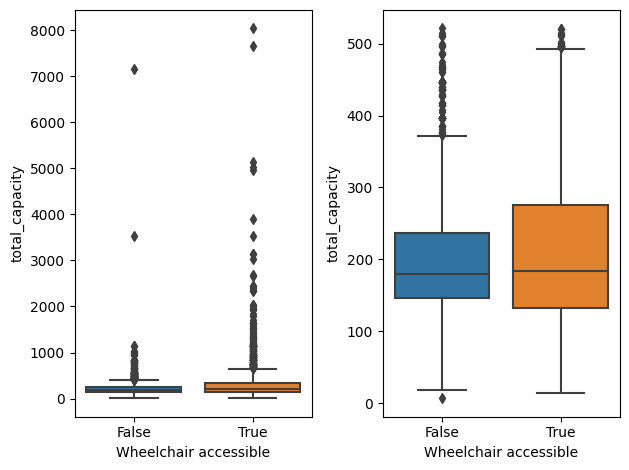

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.boxplot(x=df['Wheelchair accessible'], y=df['total_capacity'], ax=ax1)
sns.boxplot(x=df_no_outliers['Wheelchair accessible'], y=df_no_outliers['total_capacity'], ax=ax2)
fig.tight_layout()
plt.show()

The visualization shows the range of the data before and after the outliers have being removed.
Going by the brief, there is a proposed propagation from office buildings and schools to event venues. It falls to reason that a reasonable number of event venues will have a total capacity greater than 500.
Therefore, i'll be leaving the outliers in, the Scaler will handle the wide spread.

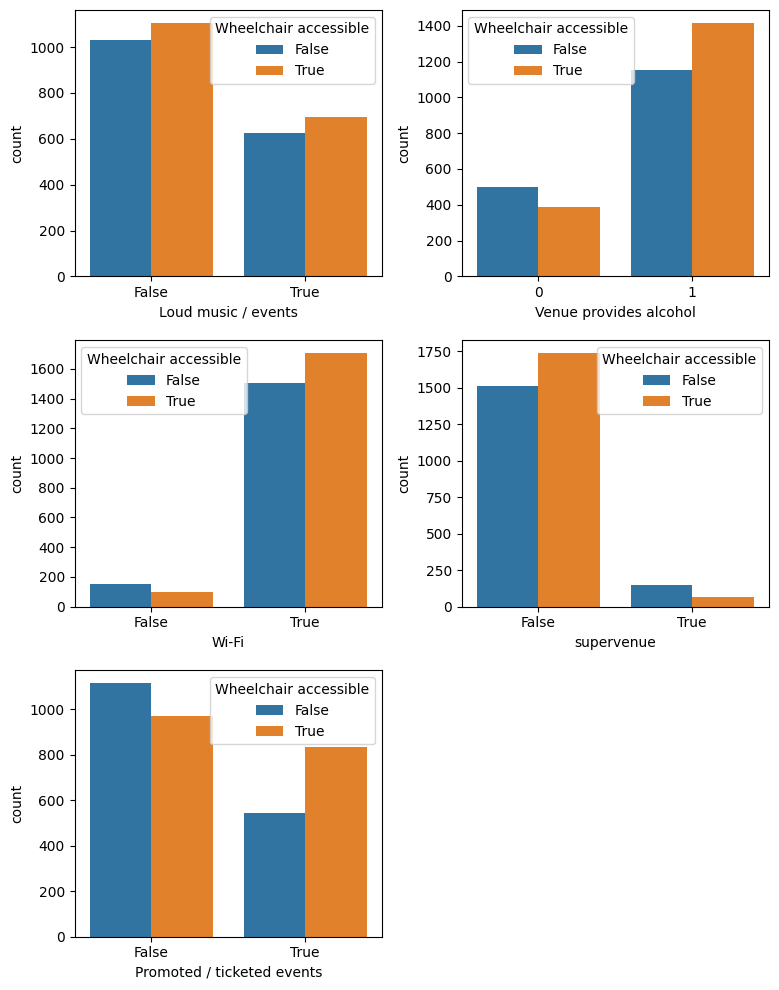

In [94]:
#Visualizing our binary variables
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
sns.countplot(x=df['Loud music / events'], hue=df['Wheelchair accessible'], ax=ax[0, 0])
sns.countplot(x=df['Venue provides alcohol'], hue=df['Wheelchair accessible'], ax=ax[0, 1])
sns.countplot(x=df['Wi-Fi'], hue=df['Wheelchair accessible'], ax=ax[1, 0])
sns.countplot(x=df['supervenue'], hue=df['Wheelchair accessible'], ax=ax[1, 1])
sns.countplot(x=df['Promoted / ticketed events'], hue=df['Wheelchair accessible'], ax=ax[2, 0])
fig.tight_layout()
fig.delaxes(ax[2,1])
plt.show()

Plotting our binary variables in the context of our target variable show a weak correlation, just like we observed in our continous variables, but we'll confirm this later on

Let's visualize the distribution of our target variable.

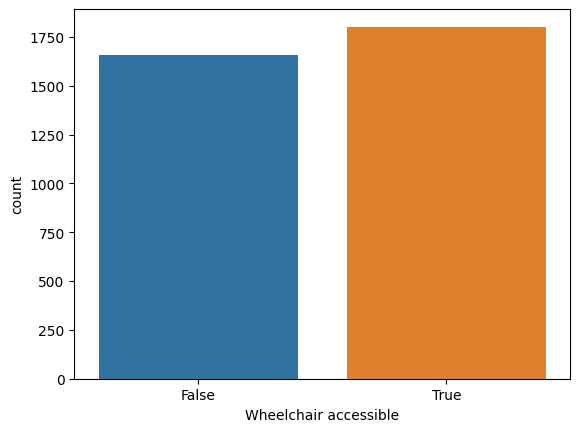

In [95]:
sns.countplot(x=df['Wheelchair accessible'])
plt.show()

In [96]:
df.columns

Index(['venue_name', 'Loud music / events', 'Venue provides alcohol', 'Wi-Fi',
       'supervenue', 'U-Shaped_max', 'max_standing', 'Theatre_max',
       'Promoted / ticketed events', 'Wheelchair accessible',
       'total_capacity'],
      dtype='object')

In [97]:
#Rearranging our columns to make for a better presentation of the correlation
df = df[['venue_name', 'Loud music / events', 'Venue provides alcohol', 'Wi-Fi',
       'supervenue', 'U-Shaped_max', 'max_standing', 'Theatre_max',
       'Promoted / ticketed events', 'total_capacity', 'Wheelchair accessible']]
df.head()

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,total_capacity,Wheelchair accessible
0,techspace aldgate east,False,0,True,False,35,0,112,False,147,False
1,green rooms hotel,True,1,True,False,40,120,80,True,240,False
2,148 leadenhall street,False,0,True,False,35,0,112,False,147,False
3,conway hall,False,0,True,False,35,60,60,False,155,False
4,gridiron building,False,0,True,False,35,0,112,False,147,False


This visualization assures us that there is no bias in the data here, though the two classes are not perfectly balanced, the difference is minimal and should not affect our model.

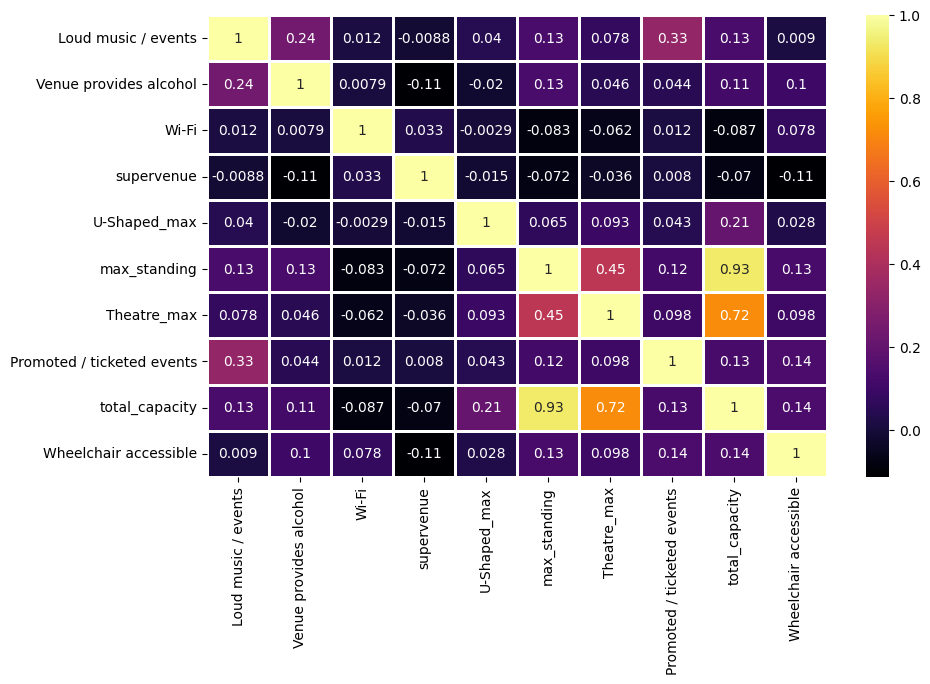

In [98]:
#Let's calculate correlation
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,cmap='inferno',linewidths=.9, ax=ax)

# Show
plt.show()

In [99]:
#For clarity
df.corr()['Wheelchair accessible'].sort_values(ascending=False)

Wheelchair accessible         1.000000
Promoted / ticketed events    0.138819
total_capacity                0.136258
max_standing                  0.127069
Venue provides alcohol        0.101641
Theatre_max                   0.098301
Wi-Fi                         0.077803
U-Shaped_max                  0.028012
Loud music / events           0.009032
supervenue                   -0.110473
Name: Wheelchair accessible, dtype: float64

As we can see the strongest correlated variable is the Promoted/ticketed events variable with a mere 13.8% while the least correlated value is the Loud music/events with a measly 0.9% and we can also observe theat the supervenue variable is negatively correlated with the target variable. 

### 4 Model Building
We are now going to try to use all the variables availaible to us to predict the target variable, all except the name variable since it is of no use to us.

The values have a wide range of deviation across the columns which can be observed in the summary statistic provided earlier in the notebook. This can adveresely affect our model and we will fix with the StandardScaler library to place all the variables on the same scale, in some sense.

We will using accuracy and precision as our classification metrics as they prioritize low False Positives values and that'll help meet the criteria set in the brief.

We will be combining different models for a higher score across our metrics.
Instead, I'll apply a few ensemble classifiers and a tree classifier to find the best performing model.

It is good practice to convert all the necessary values to integers for our model to work well.

In [100]:
#converting data types
df= df.astype({'Loud music / events':'int',
                      'Wi-Fi':'int',
                      'supervenue':'int',
                      'Promoted / ticketed events':'int',
                      'Wheelchair accessible':'int'})
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3460 entries, 0 to 3909
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   venue_name                  3460 non-null   object
 1   Loud music / events         3460 non-null   int64 
 2   Venue provides alcohol      3460 non-null   int64 
 3   Wi-Fi                       3460 non-null   int64 
 4   supervenue                  3460 non-null   int64 
 5   U-Shaped_max                3460 non-null   int64 
 6   max_standing                3460 non-null   int64 
 7   Theatre_max                 3460 non-null   int64 
 8   Promoted / ticketed events  3460 non-null   int64 
 9   total_capacity              3460 non-null   int64 
 10  Wheelchair accessible       3460 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 453.4+ KB


,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,total_capacity,Wheelchair accessible
0,techspace aldgate east,0,0,1,0,35,0,112,0,147,0
1,green rooms hotel,1,1,1,0,40,120,80,1,240,0
2,148 leadenhall street,0,0,1,0,35,0,112,0,147,0
3,conway hall,0,0,1,0,35,60,60,0,155,0
4,gridiron building,0,0,1,0,35,0,112,0,147,0


In [101]:
#importing the necessary models and metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [102]:
#Preparing our variables
X = df.drop(columns = ['venue_name', 'Wheelchair accessible'])
y = df['Wheelchair accessible']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=56)

# Scaling features
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("Train Shape:",X_train.shape)
print("Test Shape:",X_test.shape)

Train Shape: (2422, 9)
Test Shape: (1038, 9)


The classifiers we imported have different hyperparameters that I am meant to specify. While the model will run, regardless of what values i insert here, it is best to let the computer run some iterations and decide what hyperparameters are best for our model to ensure an optimal performance for our model.

In [103]:
#hyperparameter tuning
models = {}


# Gradient Booster

gb_estimator = GradientBoostingClassifier(random_state=0)
gb_param_grid = [{'n_estimators': [100, 200],
                          'max_depth': [1, 2],
                          'min_samples_split': [2, 3],
                          'min_samples_leaf': [1, 3]}]

models['gb'] = {'estimator': gb_estimator,
                        'param_grid': gb_param_grid}

# Stochastic Gradient Booster

xgb_estimator = GradientBoostingClassifier(random_state=0)
xgb_param_grid = [{'n_estimators': [100, 200],
                          'max_depth': [2, 3,],
                          'subsample': [0.5, 0.7],
                          'learning_rate': [0.001, 0.1]}]

models['xgb'] = {'estimator': xgb_estimator,
                        'param_grid': xgb_param_grid}

# Random Forest

rf_estimator = RandomForestClassifier(random_state=0)
rf_param_grid = [{'n_estimators': [300, 500],
                  'max_depth': [7, 9],
                  'min_samples_leaf': [1, 2, 3],
                          'max_features': ['sqrt', 'log2']}]

models['rf'] = {'estimator': rf_estimator,
                        'param_grid': rf_param_grid}

# Ada Boost

ada_estimator = AdaBoostClassifier(random_state=0)
ada_param_grid = [{'n_estimators': [25, 50, 75],
                   'learning_rate': [0.5, 1, 2]}]


models['ada'] = {'estimator': ada_estimator,
                 'param_grid': ada_param_grid}

# BaggClassifier

bagg_estimator = BaggingClassifier(random_state=0)
bagg_param_grid = [{'n_estimators': [10, 25, 50]}]


models['bagg'] = {'estimator': bagg_estimator,
                 'param_grid': bagg_param_grid}


#K-nearest neighbor

knn_estimator = KNeighborsClassifier()
knn_param_grid = [{'n_neighbors': [4, 5, 6, 7, 8, 9, 11, 13, 15],
                          'weights': ['uniform', 'distance'],
                          'metric': ['euclidean', 'manhattan', 'minkowski']}]

models['knn'] = {'estimator': knn_estimator,
                        'param_grid': knn_param_grid}

#DecisionTree Classifier
dt = DecisionTreeClassifier()
params_dt = {'max_depth':[2, 3, 4], 'min_samples_leaf':[0.12, 0.14, 0.16, 0.18]}

models['dt'] = {'estimator': dt,
                        'param_grid': params_dt}

tuned_models = {}

for mod in models.keys():

    gs = GridSearchCV(estimator=models[mod]['estimator'],
                      param_grid=models[mod]['param_grid'],
                      scoring='accuracy',
                      cv=2,
                      refit=True,
                      n_jobs=-1)

    scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    #print(mod + ' score: {:.1f}% +/- {:.1f}%'.format(mean_score*100, std_score*100))

    gs = gs.fit(X_train, y_train)
    print(mod + ' best hyperparameters:', gs.best_params_)

    tuned_models[mod] = {'estimator': gs.best_estimator_, 
                         'score': mean_score*100, 
                         'std': std_score*100}

gb best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
xgb best hyperparameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.5}
rf best hyperparameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}
ada best hyperparameters: {'learning_rate': 0.5, 'n_estimators': 50}
bagg best hyperparameters: {'n_estimators': 25}
knn best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}
dt best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 0.12}


In [104]:
#Storing the models
tuned_models = pd.DataFrame(tuned_models).T

print(tuned_models)

                                              estimator      score       std
gb    ([DecisionTreeRegressor(criterion='friedman_ms...   65.73017  1.868035
xgb   ([DecisionTreeRegressor(criterion='friedman_ms...  65.235154  1.970048
rf    (DecisionTreeClassifier(max_depth=7, max_featu...  65.028713  1.690121
ada   (DecisionTreeClassifier(max_depth=1, random_st...  65.936185  2.451502
bagg  (DecisionTreeClassifier(random_state=208755735...  61.932691  1.981218
knn   KNeighborsClassifier(metric='euclidean', n_nei...  62.386215  1.678752
dt    DecisionTreeClassifier(max_depth=3, min_sample...  63.831218  2.852938


In [105]:
#Fitting our test set with the tuned models and getting the metric scores
table = {}
for model in tuned_models.index:
	tuned_models['estimator'][model].fit(X_train, y_train)
	y_pred = tuned_models['estimator'][model].predict(X_test)
	table[model] = {'accuracy': metrics.accuracy_score(y_test, y_pred), 
                         'precision': metrics.precision_score(y_test, y_pred)}

print(table)

{'gb': {'accuracy': 0.6541425818882466, 'precision': 0.6606498194945848}, 'xgb': {'accuracy': 0.6599229287090559, 'precision': 0.6703703703703704}, 'rf': {'accuracy': 0.6445086705202312, 'precision': 0.6527272727272727}, 'ada': {'accuracy': 0.653179190751445, 'precision': 0.6600361663652803}, 'bagg': {'accuracy': 0.617533718689788, 'precision': 0.6310861423220974}, 'knn': {'accuracy': 0.6213872832369942, 'precision': 0.6434262948207171}, 'dt': {'accuracy': 0.6435452793834296, 'precision': 0.6371100164203612}}


In [106]:
score_table = pd.DataFrame(table).T

Looking at both scores for all the models, it seems the Stochastic Gradient Boosting Classifier is the best performing model with an accuracy of approximately 66% and a precision score of approximately 67%. Both at the 2/3 threshold put to us in the brief.

We'll visualize this to be sure then test this score by using the KFold library built for this purpose.

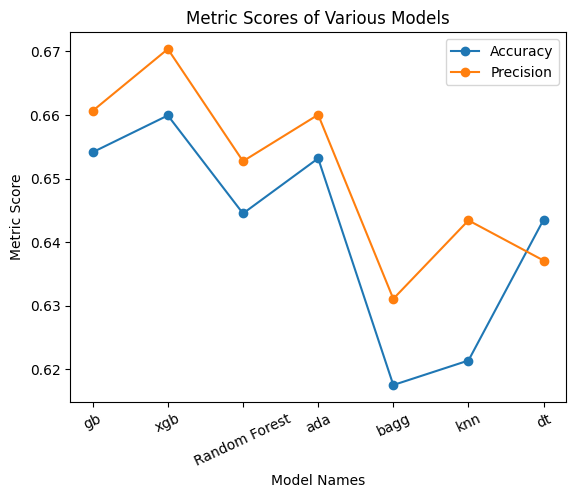

In [107]:
plt.plot(range(1,8), score_table['accuracy'], marker='o', label='Accuracy')
plt.plot(range(1,8), score_table['precision'], marker='o', label='Precision')
plt.xticks(range(1,8),['gb','xgb','Random Forest','ada','bagg','knn', 'dt'],rotation=25)
plt.title('Metric Scores of Various Models')
plt.xlabel('Model Names')
plt.ylabel("Metric Score")
plt.legend()
plt.show()

### 5 Model Evaluation

In [108]:
# Model evaluation using RepeatedStratifiedKFold Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=56)
acc_scores = cross_val_score(tuned_models['estimator']['xgb'], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
prc_scores = cross_val_score(tuned_models['estimator']['xgb'], X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print(acc_scores)
print('The average accuracy over all the folds is %.2f' % np.mean(acc_scores))
print('-'*70)
print(prc_scores)
print('The average precision over all the folds is %.2f' % np.mean(prc_scores))

[0.71676301 0.67919075 0.64450867 0.63583815 0.61849711 0.63294798
 0.69942197 0.64450867 0.68786127 0.63294798 0.66184971 0.65895954
 0.66184971 0.68208092 0.6849711  0.61560694 0.65606936 0.63872832
 0.65895954 0.69364162 0.64739884 0.62138728 0.63294798 0.66184971
 0.68208092 0.70520231 0.67919075 0.66763006 0.6849711  0.65317919]
The average accuracy over all the folds is 0.66
----------------------------------------------------------------------
[0.71354167 0.70414201 0.66666667 0.65697674 0.64117647 0.66257669
 0.7183908  0.66292135 0.70857143 0.65168539 0.68639053 0.68452381
 0.68208092 0.69230769 0.71005917 0.63128492 0.6918239  0.65053763
 0.6684492  0.71428571 0.66292135 0.6416185  0.66257669 0.66666667
 0.70588235 0.71666667 0.69491525 0.70625    0.70689655 0.68263473]
The average precision over all the folds is 0.68


As we can see above our model predicts correctly whether a venue has a ramp or not, at least 2/3 (66%) of the time as required of us. 
We'll test and visualize this using a confusion matrix on the test dataset we separated just for this step.

Text(0.5, 23.52222222222222, 'Predicted label')

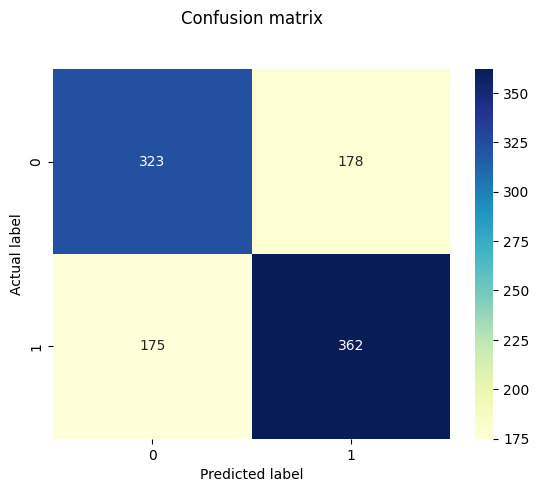

In [109]:
y_pred = np.round(tuned_models['estimator']['xgb'].predict(X_test))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [110]:
conf_mat = pd.DataFrame({"actual_response":y_test, "predicted_response":y_pred})

In [111]:
y_test.value_counts()/3

1    179.0
0    167.0
Name: Wheelchair accessible, dtype: float64

Its score has achieved the +2/3 requirement TP 364, FP 173 (< 179 limit error allowed).

Based on: "[...]at least two-thirds of venues predicted to be without a ramp should not have a ramp."

### 6 Recommendations
Better Data.
One place i struggled with was feature engineering as the data collection was done poorly as per my observations. The U-shaped max and Theather max continuous variables were filled with the mean of the columns while the max standing variable was not, and the reason for that was not clarified.

I considered removing this filled in values to bring some normalcy to my data, but then i obsereved a large amount of the data had filled in values for both this columns and a value of zero for the max-standing variable. Reverting them back to zero and caluclating the total capacity by summing the three columns would have provided us with venues with a capacity of zero, which is nonsensical. 

Also, i decided not to remove outliers in these columns because of the large amount of filled in values that skewed the data in such a way that reasonable values might then be calculated as outliers. 

Another failing of the data collection process is the poor use of the 'venue name' column, if this column was filled in properly with venue names and addresses (whether street names or district names) then i might have been able to extract that given our model more data for a better performance.
It seems to me that there was much oversight in the collection of the data.

### 7 Presentation

The presentation was done on Google Slides and is accessible by this link.
https://docs.google.com/presentation/d/1nMpN1Q6gUzqire-X8qy3ttBZzK7uuWY_SxM41LynpBs/edit?usp=sharing